# NLP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import re

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df_ = pd.read_csv('df_copom_label_en.csv')

In [3]:
df_.head(1)

,Unnamed: 0,meeting_number,date_x,date_y,selic,decision,decision_txt,type,text,num_words,text_raw,num_words_raw,label_hawk_dove,label_next_meet
0,0,117,2006/03/08,2006/03/08,16.5,-0.75,decrease,statement,"march meeting , banco central brasil 's moneta...",55.0,"In the March Meeting, the Banco Central do Br...",67.0,dovish,decrease


In [4]:
# df_ = df_copom[(df_copom['type'] == 'statement')]

In [5]:
# df_.shape

In [6]:
def count_words_ponct(text):
    return len(re.findall(r'[^\w\s]|\w+', text))

In [7]:
df_.loc[100,('num_words')]

528.0

In [8]:
count_words_ponct(df_.loc[100,('text')])

610

In [9]:
df_['text']

0      march meeting , banco central brasil 's moneta...
1      april meeting , monetary policy committee ( co...
2      may meeting , monetary policy committee ( copo...
3      july meeting , copom unanimously decided reduc...
4      august meeting , copom unanimously decided red...
                             ...                        
158    252nd meeting , copom decided maintain selic r...
159    A) Update of economic outlook and Copom’s scen...
160    since previous meeting monetary policy committ...
161    A) Update of economic outlook and Copom’s scen...
162    global environment remains challenging . episo...
Name: text, Length: 163, dtype: object

In [10]:
df_['num_words_ponct'] = df_['text'].apply(count_words_ponct)

In [11]:
df_['num_words_ponct']

0        58
1        37
2        37
3        32
4        38
       ... 
158     541
159    3167
160     494
161    2864
162     474
Name: num_words_ponct, Length: 163, dtype: int64

In [12]:
df_['num_words_ponct'].unique()

array([  58,   37,   32,   38,   33,   52,   80,   35,   56,   69,   68,
         41,   39,   54,   55,   64,   42,   50,   74,   81,   72,   27,
         79,   66,   85,   90,   65,   45,   46,   59,   96,   34,   88,
        234,   57,   47,   73,  121,  125,  154,   61,   48,  162,   53,
         36,   60,   40,  113,  123,  122,  256,  440,  521,  444,  477,
        385,  438,  384,  398,  475,  466,  499,  463,  458,  531,  610,
        616,  565,  618,  518,  530,  538,  557,  501,  515,  546,  579,
        536,  485,  508,  609,  578,  602, 2165,  663, 2097,  657, 1908,
        715, 1888,  576, 1759, 1944,  664, 1425,  552,  612, 1696, 1617,
        240, 1624,  667, 1531,  511,  527, 1481,  525, 1592,  623, 1825,
       2064,  690, 2438,  550, 2510, 2166,  581, 2511, 3056,  541, 3167,
        494, 2864,  474], dtype=int64)

In [13]:
# df_ = df_[(df_['num_words_ponct'] <= 510)].copy()

In [14]:
df_.shape

(163, 15)

<Axes: >

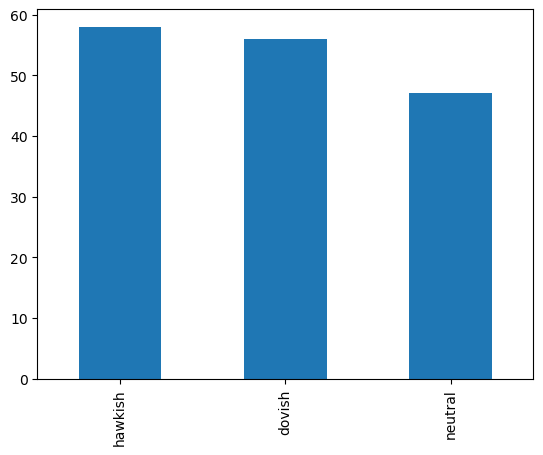

In [15]:
df_['label_hawk_dove'].value_counts().plot(kind='bar')

In [16]:
df_['label_hawk_dove']

0       dovish
1       dovish
2       dovish
3       dovish
4       dovish
        ...   
158    neutral
159    neutral
160    neutral
161        NaN
162        NaN
Name: label_hawk_dove, Length: 163, dtype: object

In [17]:
target_map = {'dovish': 0, 'hawkish': 1, 'neutral': 2}
df_['target'] = df_['label_hawk_dove'].map(target_map)

In [18]:
df_ = df_[df_['target'].notna()]

In [19]:
df_['target'] = df_['target'].astype(int)

In [20]:
df_['target'].unique()

array([0, 1, 2])

In [21]:
df_.shape

(161, 16)

In [22]:
df = df_[['text', 'target']]
df.columns = ['sentence', 'label']

In [23]:
df.head()

,sentence,label
0,"march meeting , banco central brasil 's moneta...",0
1,"april meeting , monetary policy committee ( co...",0
2,"may meeting , monetary policy committee ( copo...",0
3,"july meeting , copom unanimously decided reduc...",0
4,"august meeting , copom unanimously decided red...",0


In [24]:
df.to_csv('data_copom_transf_en_all.csv', index=None)

#### Convert to dataset

In [25]:
from datasets import load_dataset

raw_dataset = load_dataset('csv', data_files='data_copom_transf_en_all.csv')

C:\Users\ftrav\anaconda3\envs\tcc_gpu2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting data files: 100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.86it/s]


Dataset csv downloaded and prepared to C:/Users/ftrav/.cache/huggingface/datasets/csv/default-ace12619b74aa844/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.10it/s]


In [26]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 161
    })
})

#### Split test and train

In [27]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=2015)

In [28]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 112
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 49
    })
})

## Model

In [29]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa")

# model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa")

@article{shah2023trillion, 
  title={Trillion Dollar Words: A New Financial Dataset, Task & Market Analysis},
  author={Shah, Agam and Paturi, Suvan and Chava, Sudheer},
  journal={Available at SSRN 4447632},
  year={2023}
}

https://huggingface.co/gtfintechlab/FOMC-RoBERTa?text=Such+a+directive+would+imply+that+any+tightening+should+be+implemented+promptly+if+developments+were+perceived+as+pointing+to+rising+inflation.

In [30]:
checkpoint = 'gtfintechlab/FOMC-RoBERTa'

#### Tokenizer

In [31]:
from transformers import AutoTokenizer

In [32]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint, do_lower_case=True, truncation='longest_first') #, do_basic_tokenize=True)

In [33]:
# truncation="only_first" ensure that the beginning of the sentence is preserved
# "only_second" keeps the end of the text
# "longest_first" preserves as much text as possible from both ends

def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation='longest_first') 

In [34]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

#### Training

In [35]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

In [37]:
from torchinfo import summary

In [38]:
summary(model)

Layer (type:depth-idx)                                       Param #
RobertaForSequenceClassification                             --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   51,471,360
│    │    └─Embedding: 3-2                                   526,336
│    │    └─Embedding: 3-3                                   1,024
│    │    └─LayerNorm: 3-4                                   2,048
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  302,309,376
├─RobertaClassificationHead: 1-2                             --
│    └─Linear: 2-3                                           1,049,600
│    └─Dropout: 2-4                                          --
│    └─Linear: 2-5                                           3,0

In [39]:
def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

In [40]:
training_args = TrainingArguments(
    output_dir='training_dir/en/all',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [41]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [42]:
trainer.train()

C:\Users\ftrav\anaconda3\envs\tcc_gpu2\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.103721,0.265306,0.139785
2,No log,0.933195,0.551020,0.454131
3,No log,1.036013,0.714286,0.713971
4,No log,0.990086,0.714286,0.716092
5,No log,0.988148,0.714286,0.716092


TrainOutput(global_step=35, training_loss=0.9298397609165736, metrics={'train_runtime': 1953.3049, 'train_samples_per_second': 0.287, 'train_steps_per_second': 0.018, 'total_flos': 521883326791680.0, 'train_loss': 0.9298397609165736, 'epoch': 5.0})

In [47]:
!dir training_dir\en\all

 Volume in drive C has no label.
 Volume Serial Number is 5AAA-7C2A

 Directory of C:\Users\ftrav\Documents\Insper_tcc\training_dir\en\all

07/02/2023  03:29 PM    <DIR>          .
07/02/2023  02:53 PM    <DIR>          ..
07/02/2023  03:10 PM    <DIR>          checkpoint-14
07/02/2023  03:17 PM    <DIR>          checkpoint-21
07/02/2023  03:23 PM    <DIR>          checkpoint-28
07/02/2023  03:30 PM    <DIR>          checkpoint-35
07/02/2023  03:04 PM    <DIR>          checkpoint-7
07/02/2023  02:57 PM    <DIR>          runs
               0 File(s)              0 bytes
               8 Dir(s)  16,854,282,240 bytes free


#### Test

In [48]:
from transformers import pipeline, AutoConfig

In [49]:
config = AutoConfig.from_pretrained(checkpoint)

In [51]:
savedmodel = pipeline('text-classification',
                      model='training_dir/en/all/checkpoint-35/',
                      tokenizer=tokenizer, 
                      config=config,
                      device=0,
                      framework="pt")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [52]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 49
})

In [53]:
# count_words_ponct(split['test']['sentence'][2])

In [54]:
test_pred = savedmodel(split['test']['sentence'],
                       batch_size=128, 
                       truncation="longest_first")

In [55]:
for i in range(len(split['test']['label'])):
    print (split['test']['label'][i], test_pred[i])

1 {'label': 'LABEL_1', 'score': 0.8263910412788391}
2 {'label': 'LABEL_1', 'score': 0.48408085107803345}
2 {'label': 'LABEL_2', 'score': 0.585581362247467}
0 {'label': 'LABEL_0', 'score': 0.9820173382759094}
2 {'label': 'LABEL_2', 'score': 0.7282717823982239}
2 {'label': 'LABEL_2', 'score': 0.551218569278717}
1 {'label': 'LABEL_1', 'score': 0.8249520063400269}
0 {'label': 'LABEL_0', 'score': 0.9785659909248352}
0 {'label': 'LABEL_0', 'score': 0.9822155237197876}
1 {'label': 'LABEL_2', 'score': 0.7442229986190796}
0 {'label': 'LABEL_0', 'score': 0.9833464622497559}
2 {'label': 'LABEL_2', 'score': 0.701949954032898}
2 {'label': 'LABEL_1', 'score': 0.8043205142021179}
1 {'label': 'LABEL_1', 'score': 0.8597477078437805}
0 {'label': 'LABEL_1', 'score': 0.8438470959663391}
1 {'label': 'LABEL_1', 'score': 0.8252880573272705}
1 {'label': 'LABEL_0', 'score': 0.9775057435035706}
1 {'label': 'LABEL_0', 'score': 0.9827389717102051}
2 {'label': 'LABEL_2', 'score': 0.7714009881019592}
1 {'label': 'L

In [56]:
def get_label(d):
    return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [57]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.7142857142857143


In [58]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.7160919540229885


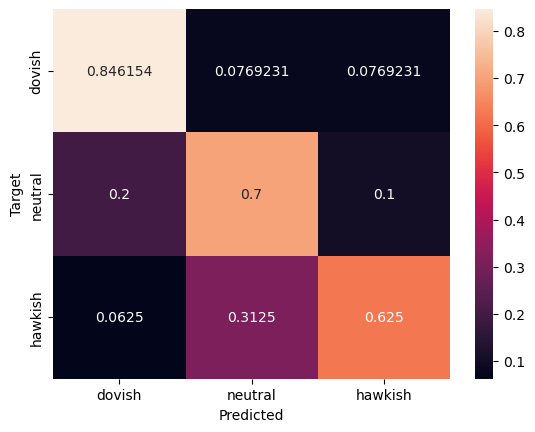

In [59]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
    classes = ['dovish', 'neutral', 'hawkish']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(split['test']['label'], test_pred, normalize='true')
plot_cm(cm)

In [60]:
new_text = 'Considering the assessed scenarios, the balance of risks, and the broad array of available information, Copom decided to maintain the Selic rate at 13.75% p.a. and judges that this decision is consistent with the strategy for inflation convergence to a level around its target throughout the relevant horizon for monetary policy, which includes the year of 2024. Without compromising its fundamental objective of ensuring price stability, this decision also implies smoothing economic fluctuations and fostering full employment. The current context, characterized by a stage in which the disinflationary process tends to be slower and in an environment of deanchored inflation expectations continues to require caution and parcimony. Copom reaffirms its commitment to set monetary policy to meet the targets and judges that the strategy of maintaining the Selic rate for a long period has been adequate to ensure the convergence of inflation. The Committee emphasizes that it will persist until the disinflationary process consolidates and inflation expectations anchor around its targets. The Committee judges that the current scenario demands patience and serenity in the conduct of monetary policy and reminds that the future steps of monetary policy will depend on the inflationary dynamics, especially the components that are more sensitive to monetary policy and economic activity, on inflation expectations, in particular the longer-term ones, on its inflation projections, on the output gap, and on the balance of risks.'

In [61]:
new_test_pred = savedmodel(new_text,
                           batch_size=128,
                           truncation="longest_first")

In [62]:
new_test_pred

[{'label': 'LABEL_2', 'score': 0.7028123736381531}]

In [63]:
target_map

{'dovish': 0, 'hawkish': 1, 'neutral': 2}

## gtfintechlab/FOMC-RoBERTa

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

tokenizer_raw = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)
model_raw = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config_raw = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")

classifier_raw = pipeline('text-classification', 
                          model=model_raw, 
                          tokenizer=tokenizer_raw, 
                          config=config_raw, 
                          device=0, 
                          framework="pt")

In [ ]:
new_text_raw = 'Considering the assessed scenarios, the balance of risks, and the broad array of available information, Copom decided to maintain the Selic rate at 13.75% p.a. and judges that this decision is consistent with the strategy for inflation convergence to a level around its target throughout the relevant horizon for monetary policy, which includes the year of 2024. Without compromising its fundamental objective of ensuring price stability, this decision also implies smoothing economic fluctuations and fostering full employment. The current context, characterized by a stage in which the disinflationary process tends to be slower and in an environment of deanchored inflation expectations continues to require caution and parcimony. Copom reaffirms its commitment to set monetary policy to meet the targets and judges that the strategy of maintaining the Selic rate for a long period has been adequate to ensure the convergence of inflation. The Committee emphasizes that it will persist until the disinflationary process consolidates and inflation expectations anchor around its targets. The Committee judges that the current scenario demands patience and serenity in the conduct of monetary policy and reminds that the future steps of monetary policy will depend on the inflationary dynamics, especially the components that are more sensitive to monetary policy and economic activity, on inflation expectations, in particular the longer-term ones, on its inflation projections, on the output gap, and on the balance of risks.'

In [ ]:
results = classifier_raw([new_text_raw], 
                      batch_size=128, truncation="only_first")

print(results)

In [ ]:
target_map